In [3]:
import os, yaml, sys
import numpy as np
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import BrainAreas, RSA, load_img_natraster
from general_utils.dRSA import across_areas_dRSA

In [34]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    monkey_name: str = 'paul' 
    date: str = '230204'
    brain_area: str = 'AIT'
    new_fs: int = 100 # Hz
    RDM_metric_A: str = 'correlation'
    RDM_metric_B: str = 'cosine'
    RSA_metric: str = 'correlation'
cfg = Cfg()

In [5]:
raster = load_img_natraster(paths, cfg.monkey_name, cfg.date, new_fs=cfg.new_fs)

In [6]:
ba_obj = BrainAreas(cfg.monkey_name)
ba_raster = ba_obj.slice_brain_area(raster, cfg.brain_area)

In [ ]:
peak_act = np.argmax(np.mean(ba_raster.get_array(), axis=(0,2))) # selects the timepoint with the highest mean population activity
peak_slice = ba_raster[peak_act]
N = peak_slice.shape[1]

In [35]:
rsa_obj_A = RSA(cfg.RDM_metric_A)
rsa_obj_B = RSA(cfg.RDM_metric_B)

In [36]:
rsa_obj_A.compute_RDM(peak_slice, "signal")
rsa_obj_B.compute_RDM(peak_slice, "signal")

array([0.21580625, 0.24965841, 1.01544869, ..., 0.38951951, 0.42779046,
       0.14796907])

In [37]:
print("correlation between the two matrices:", np.round(np.corrcoef(rsa_obj1.get_RDM("signal"), rsa_obj2.get_RDM("signal"))[0,1],2))

correlation between the two matrices: 0.64


In [38]:
m_A = squareform(rsa_obj_A.get_RDM("signal")) 
m_B = squareform(rsa_obj_B.get_RDM("signal"))
# m1 = m1 + np.eye(m1.shape[0])*10e10
# m2 = m2 + np.eye(m2.shape[0])*10e10

In [22]:
"""
distance_ranks
Creates a matrix of distance ranks from an RDM. 
I.e. the element (i,j) will tell you the rank of the point i 
with respect to the point j. So the ith column tells you the
distance rank of the points with respect to the ith point.
The matrix is not symmetric anymore and only the columns are 
interpretable. The diagonal ranks are filled with N+1 vals.
We take two argsort because 
- 1st argsort gives you the row-wise (i.e. each column is treated 
independently) index that if, applied to the original vector, 
would give you a vector with the values of the original vector 
in increasing order.  
So here in each column: the position in the vector gives you the
value rank, while its value the index in the original vector.
- 2nd argsort gives you the distance rank of the element i (row) in
the neighborhood of the element j (col).
In vector terms, it yields the vector that if applied to the output
of the first argsort, would give you np.arange(0, N) (the order of 
the ranks). So the returned vector has again the value rank in the
position and the index in its value, but since it's applied to the 
output of the first argsort, it returns the distance ranks.
E.g. (This is applied to every column of RDM)
Input vector: [3,5,4,2] 
Output 1st argsort: [3,0,2,1]
Output 2nd argsort: [1,3,2,0]
2 is the 1st NN, 3 is the 2nd, etc...

OUTPUT:
- ranks: np.ndarray (N,N) -> Interpretable columns, the ith element in column j 
is the distance rank of point i in the neighborhood of j.
"""
def distance_ranks(RDM):
    RDM = RDM.copy()
    np.fill_diagonal(RDM, np.inf)
    order = np.argsort(RDM, axis=0)
    ranks = np.argsort(order, axis=0)
    ranks = ranks + 2*np.eye(ranks.shape[0])
    return ranks
# EOF

In [28]:
# test example 
RDM = np.array([
    [0.0, 0.1, 0.4, 0.9],
    [0.1, 0.0, 0.3, 0.2],
    [0.4, 0.3, 0.0, 0.3],
    [0.9, 0.8, 0.2, 0.0],
])
dr = distance_ranks(RDM)
print(dr)
print('\n', np.argmin(dr, axis=1))

[[5. 0. 2. 2.]
 [0. 5. 1. 0.]
 [1. 1. 5. 1.]
 [2. 2. 0. 5.]]

 [1 0 0 2]


In [33]:
dr[np.argmin(dr, axis=0), np.arange(dr.shape[0])]

array([0., 0., 0., 0.])

In [39]:
r_A = distance_ranks(m_A)
r_B = distance_ranks(m_B)


In [47]:
NN_A = np.argmin(r_A, axis=0)
r_B_given_NN_A = r_B[NN_A, np.arange(N)] # i.e. r^B | r^A = 1

NN_B = np.argmin(r_B, axis=0)
r_A_given_NN_B = r_A[NN_B, np.arange(N)] # i.e. r^B | r^A = 1

In [48]:
delta_A2B = 2*np.mean(r_B_given_NN_A)/N
delta_B2A = 2*np.mean(r_A_given_NN_B)/N

In [61]:
print("The lower the value, the higher the predictivity:")
print(f"Information Imbalance {cfg.RDM_metric_A} to predict {cfg.RDM_metric_B} {delta_A2B:.3f} \naverage rank rank^B | r^A=1 {np.mean(r_B_given_NN_A):.3f}")
print(f"Information Imbalance {cfg.RDM_metric_B} to predict {cfg.RDM_metric_A} {delta_B2A:.3f} \naverage rank rank^A | r^B=1 {np.mean(r_A_given_NN_B):.3f}")

The lower the value, the higher the predictivity:
Information Imbalance correlation to predict cosine 0.096 
average rank rank^B | r^A=1 210.054
Information Imbalance cosine to predict correlation 0.002 
average rank rank^A | r^B=1 3.304


In [64]:
# test if my function is correct against their tutorial
# sample dataset

N = 1000

cov = np.identity(3)
cov[-1, -1] = 0.2**2  # variance along z is much smaller!
mean = np.zeros(3)
X = np.random.multivariate_normal(mean=mean, cov=cov, size=(N)).T

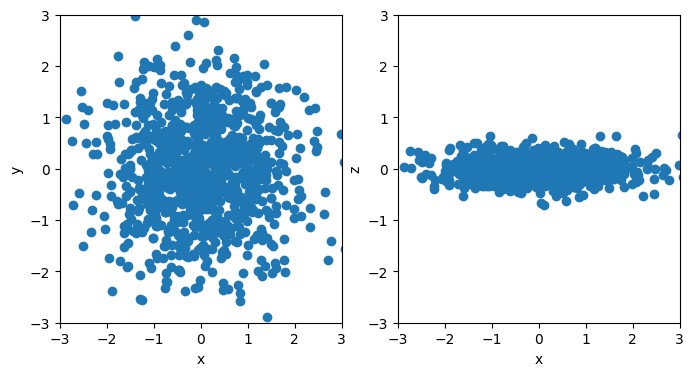

In [83]:
# plot the sampled points

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.scatter(X.T[:, 0], X.T[:, 1])
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.scatter(X.T[:, 0], X.T[:, 2])
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)
ax2.set_xlabel("x")
ax2.set_ylabel("z")
plt.show()

In [72]:
xyz = RSA("euclidean")
xy = RSA("euclidean")
z = RSA("euclidean")

In [94]:
xyz.compute_RDM(X, "signal")
xy.compute_RDM(X[:2, :], "signal")
z.compute_RDM(X[2:3, :], "signal")

array([0.38680613, 0.19248075, 0.53351496, ..., 0.25883385, 0.16869381,
       0.09014004])

In [95]:
r_xyz = distance_ranks(squareform(xyz.get_RDM("signal")))
r_xy = distance_ranks(squareform(xy.get_RDM("signal")))
r_z = distance_ranks(squareform(z.get_RDM("signal")))


In [96]:
NN_xyz = np.argmin(r_xyz, axis=0)
NN_xy = np.argmin(r_xy, axis=0)
NN_z = np.argmin(r_z, axis=0)

r_xy_given_NN_xyz = r_xy[NN_xyz, np.arange(N)] # i.e. r^B | r^A = 1
r_xyz_given_NN_xy = r_xyz[NN_xy, np.arange(N)] # i.e. r^B | r^A = 1
r_z_given_NN_xyz = r_z[NN_xyz, np.arange(N)] # i.e. r^B | r^A = 1
r_xyz_given_NN_z = r_xyz[NN_z, np.arange(N)] # i.e. r^B | r^A = 1

delta_xyz2xy = 2*np.mean(r_xy_given_NN_xyz)/N
delta_xy2xyz = 2*np.mean(r_xyz_given_NN_xy)/N
delta_z2xyz = 2*np.mean(r_xyz_given_NN_z)/N
delta_xyz2z = 2*np.mean(r_z_given_NN_xyz)/N

In [98]:
print(delta_xyz2xy, delta_xy2xyz)
print(delta_xyz2z, delta_z2xyz)

0.003676 0.021911999999999997
0.353572 0.98956


(0.0, 1.0)

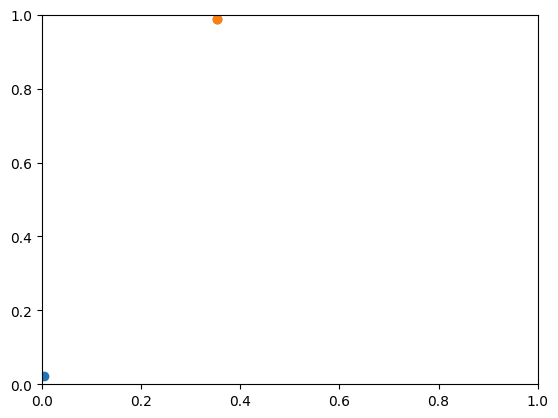

In [99]:
plt.scatter([delta_xyz2xy, delta_xyz2z], [delta_xy2xyz, delta_z2xyz])
plt.scatter(delta_xyz2z, delta_z2xyz)
plt.xlim(0,1)
plt.ylim(0,1)